In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
from scipy.sparse.csgraph import shortest_path
import matplotlib.colors as mcol
from matplotlib import cm
from ot.gromov import fgw_barycenters

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from modules.graph import networkx_to_dash

In [2]:
def find_thresh(C, inf=0.5, sup=3, step=10):
    """ Trick to find the adequate thresholds from where value of the C matrix are considered close enough to say that nodes are connected
        Tthe threshold is found by a linesearch between values "inf" and "sup" with "step" thresholds tested.
        The optimal threshold is the one which minimizes the reconstruction error between the shortest_path matrix coming from the thresholded adjency matrix
        and the original matrix.
    Parameters
    ----------
    C : ndarray, shape (n_nodes,n_nodes)
            The structure matrix to threshold
    inf : float
          The beginning of the linesearch
    sup : float
          The end of the linesearch
    step : integer
            Number of thresholds tested
    """
    dist = []
    search = np.linspace(inf, sup, step)
    for thresh in search:
        Cprime = sp_to_adjency(C, 0, thresh)
        SC = shortest_path(Cprime, method='D')
        SC[SC == float('inf')] = 100
        dist.append(np.linalg.norm(SC - C))
    return search[np.argmin(dist)], dist


def sp_to_adjency(C, threshinf=0.2, threshsup=1.8):
    """ Thresholds the structure matrix in order to compute an adjency matrix.
    All values between threshinf and threshsup are considered representing connected nodes and set to 1. Else are set to 0
    Parameters
    ----------
    C : ndarray, shape (n_nodes,n_nodes)
        The structure matrix to threshold
    threshinf : float
        The minimum value of distance from which the new value is set to 1
    threshsup : float
        The maximum value of distance from which the new value is set to 1
    Returns
    -------
    C : ndarray, shape (n_nodes,n_nodes)
        The threshold matrix. Each element is in {0,1}
    """
    H = np.zeros_like(C)
    np.fill_diagonal(H, np.diagonal(C))
    C = C - H
    C = np.minimum(np.maximum(C, threshinf), threshsup)
    C[C == threshsup] = 0
    C[C != 0] = 1

    return C


def build_noisy_circular_graph(N=20, mu=0, sigma=0.3, with_noise=False, structure_noise=False, p=None):
    """ Create a noisy circular graph
    """
    g = nx.Graph()
    g.add_nodes_from(list(range(N)))
    for i in range(N):
        noise = float(np.random.normal(mu, sigma, 1))
        if with_noise:
            g.add_node(i, attr_name=math.sin((2 * i * math.pi / N)) + noise)
        else:
            g.add_node(i, attr_name=math.sin(2 * i * math.pi / N))
        g.add_edge(i, i + 1)
        if structure_noise:
            randomint = np.random.randint(0, p)
            if randomint == 0:
                if i <= N - 3:
                    g.add_edge(i, i + 2)
                if i == N - 2:
                    g.add_edge(i, 0)
                if i == N - 1:
                    g.add_edge(i, 1)
    g.add_edge(N, 0)
    noise = float(np.random.normal(mu, sigma, 1))
    if with_noise:
        g.add_node(N, attr_name=math.sin((2 * N * math.pi / N)) + noise)
    else:
        g.add_node(N, attr_name=math.sin(2 * N * math.pi / N))
    return g


def graph_colors(nx_graph, vmin=0, vmax=7):
    cnorm = mcol.Normalize(vmin=vmin, vmax=vmax)
    cpick = cm.ScalarMappable(norm=cnorm, cmap='viridis')
    cpick.set_array([])
    val_map = {}
    for k, v in nx.get_node_attributes(nx_graph, 'attr_name').items():
        val_map[k] = cpick.to_rgba(v)
    colors = []
    for node in nx_graph.nodes():
        colors.append(val_map[node])
    return colors

In [3]:
np.random.seed(30)
X0 = []
for k in range(9):
    X0.append(build_noisy_circular_graph(np.random.randint(15, 25), with_noise=True, structure_noise=True, p=3))

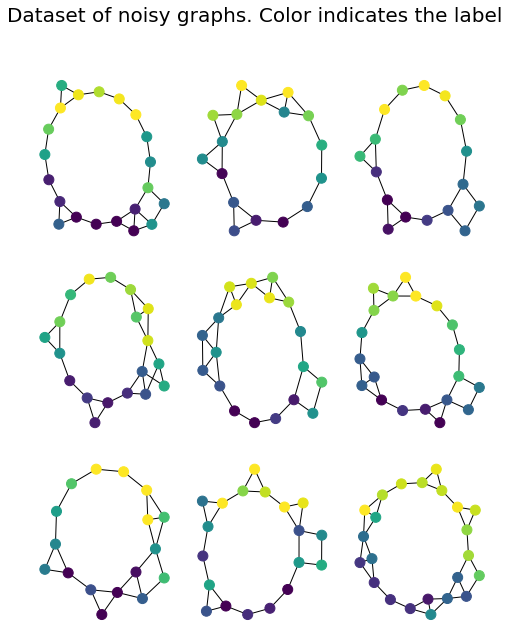

In [4]:
plt.figure(figsize=(8, 10))
for i in range(len(X0)):
    plt.subplot(3, 3, i + 1)
    g = X0[i]
    pos = nx.kamada_kawai_layout(g)
    nx.draw(g, pos=pos, node_color=graph_colors(g, vmin=-1, vmax=1), with_labels=False, node_size=100)
plt.suptitle('Dataset of noisy graphs. Color indicates the label', fontsize=20)
plt.show()

In [5]:
Cs = [shortest_path(nx.adjacency_matrix(x)) for x in X0]
ps = [np.ones(len(x.nodes())) / len(x.nodes()) for x in X0]
Ys = [np.array([v for (k, v) in nx.get_node_attributes(x, 'attr_name').items()]).reshape(-1, 1) for x in X0]
lambdas = np.array([np.ones(len(Ys)) / len(Ys)]).ravel()
sizebary = 15  # we choose a barycenter with 15 nodes

A, C, log = fgw_barycenters(sizebary, Ys, Cs, ps, lambdas, alpha=0.95, log=True)

In [6]:
bary = nx.from_numpy_matrix(sp_to_adjency(C, threshinf=0, threshsup=find_thresh(C, sup=100, step=100)[0]))
for i, v in enumerate(A.ravel()):
    bary.add_node(i, attr_name=v)

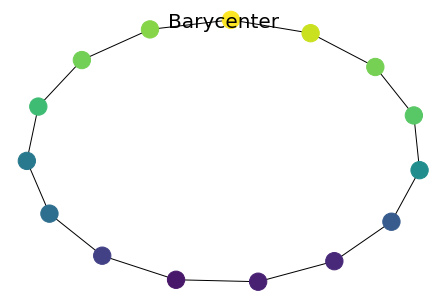

In [7]:
pos = nx.kamada_kawai_layout(bary)
nx.draw(bary, pos=pos, node_color=graph_colors(bary, vmin=-1, vmax=1), with_labels=False)
plt.suptitle('Barycenter', fontsize=20)
plt.show()

## learn model on bayrcenter

In [8]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from modules.static import StaticFramework
from modules.staticModels.models import *

Using backend cpu


In [9]:
model = SCAN()
model = Eigenspoke(k=1)
model = Oddball()

In [10]:
models = {
    'scan':SCAN(),
    'eigenspoke':Eigenspoke(k=1),
    'oddball':Oddball(),
}

In [11]:
s = StaticFramework(model)

In [12]:
for k,v in models.items():
    s = StaticFramework(v)
    for i in range(len(X0)):
        g = X0[i]
        node_df,edge_df = s.fit(g)
        nx.set_node_attributes(g, node_df.to_dict()['y_pred'], f'{k}_pred')

Outliters:
[0, 16, 17]
Outliters:
[1, 2, 3]
Outliters:
[0, 13, 15]
Outliters:
[0, 1, 2, 15, 16]
Outliters:
[0, 15, 17]
Outliters:
[0, 15, 16, 18]
Outliters:
[0, 1, 13]
Outliters:
[1, 2, 16]
Outliters:
[0, 19, 21]
alpha=1.5111898906702432
maxOutLine=0.9060559140043525
maxLOFScore=1.0163628130356934
alpha=1.3203089321603936
maxOutLine=0.6888570299685676
maxLOFScore=1.0168280582719198
alpha=1.2911893457494554
maxOutLine=0.8549264559330976
maxLOFScore=1.0218953930674854
alpha=1.2969325522922162
maxOutLine=0.954770325712637
maxLOFScore=1.0224177060027002
alpha=1.7314622907016128
maxOutLine=1.0576506964352774
maxLOFScore=1.0181664345047716
alpha=1.3625114349710912
maxOutLine=0.8978912306674237
maxLOFScore=1.0163923254290728
alpha=1.4033122606841917
maxOutLine=0.8786131306866876
maxLOFScore=1.015436752218906
alpha=1.1751481613956014
maxOutLine=0.7494214677503104
maxLOFScore=1.0218434748779484
alpha=1.4060941235157132
maxOutLine=1.1247095215737635
maxLOFScore=1.0432226708218881


/home/harrison/.virtualenvs/anomaly/lib/python3.8/site-packages/sklearn/neighbors/_lof.py:274: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
/home/harrison/.virtualenvs/anomaly/lib/python3.8/site-packages/sklearn/neighbors/_lof.py:274: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
/home/harrison/.virtualenvs/anomaly/lib/python3.8/site-packages/sklearn/neighbors/_lof.py:274: UserWarning: n_neighbors (20) is greater than the total number of samples (19). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
/home/harrison/.virtualenvs/anomaly/lib/python3.8/site-packages/sklearn/neighbors/_lof.py:274: UserWarning: n_neighbors (20) is gr

In [15]:
for i in range(len(X0)):
    networkx_to_dash(X0[i],filename=f"../datasets/graph/example{i}")

{'id': 0, 'label': 0, 'attr_name': 0.5272357764212233, 'scan_pred': 0, 'eigenspoke_pred': 1, 'oddball_pred': 0}
{'id': 1, 'label': 1, 'attr_name': -0.025199877085830824, 'scan_pred': 0, 'eigenspoke_pred': 0, 'oddball_pred': 0}
{'id': 2, 'label': 2, 'attr_name': 0.0699965237738629, 'scan_pred': 0, 'eigenspoke_pred': 0, 'oddball_pred': 0}
{'id': 3, 'label': 3, 'attr_name': 1.2845456050796096, 'scan_pred': 0, 'eigenspoke_pred': 0, 'oddball_pred': 0}
{'id': 4, 'label': 4, 'attr_name': 0.9668589677172028, 'scan_pred': 0, 'eigenspoke_pred': 0, 'oddball_pred': 0}
{'id': 5, 'label': 5, 'attr_name': 0.764613354205606, 'scan_pred': 0, 'eigenspoke_pred': 0, 'oddball_pred': 0}
{'id': 6, 'label': 6, 'attr_name': 0.9465963338268331, 'scan_pred': 0, 'eigenspoke_pred': 0, 'oddball_pred': 0}
{'id': 7, 'label': 7, 'attr_name': 0.2480910233652449, 'scan_pred': 0, 'eigenspoke_pred': 0, 'oddball_pred': 0}
{'id': 8, 'label': 8, 'attr_name': 1.0029394019302478, 'scan_pred': 0, 'eigenspoke_pred': 0, 'oddball_

In [16]:
# Fitted predictions for nodes/edges
for k,v in models.items():
    s = StaticFramework(v)
    node_df, edge_df = s.fit(bary)
    nx.set_node_attributes(bary, node_df.to_dict()['y_pred'], f'{k}_pred')
networkx_to_dash(bary,filename=f"../datasets/graph/barycentre_example")

Outliters:
[0, 3, 9, 12]
alpha=0.0
maxOutLine=0
maxLOFScore=1.0
{'id': 0, 'label': 0, 'attr_name': -0.7767922360415851, 'scan_pred': 0, 'eigenspoke_pred': 1, 'oddball_pred': 1}
{'id': 1, 'label': 1, 'attr_name': 0.47851648036813804, 'scan_pred': 0, 'eigenspoke_pred': 0, 'oddball_pred': 0}
{'id': 2, 'label': 2, 'attr_name': 0.5813688628121336, 'scan_pred': 0, 'eigenspoke_pred': 0, 'oddball_pred': 0}
{'id': 3, 'label': 3, 'attr_name': 1.0152530429029547, 'scan_pred': 0, 'eigenspoke_pred': 1, 'oddball_pred': 0}
{'id': 4, 'label': 4, 'attr_name': 0.8415822883255544, 'scan_pred': 0, 'eigenspoke_pred': 0, 'oddball_pred': 0}
{'id': 5, 'label': 5, 'attr_name': -0.2844120448531646, 'scan_pred': 0, 'eigenspoke_pred': 0, 'oddball_pred': 0}
{'id': 6, 'label': 6, 'attr_name': 0.37539523649995354, 'scan_pred': 0, 'eigenspoke_pred': 0, 'oddball_pred': 0}
{'id': 7, 'label': 7, 'attr_name': -0.6139558876195498, 'scan_pred': 0, 'eigenspoke_pred': 0, 'oddball_pred': 0}
{'id': 8, 'label': 8, 'attr_name': 

/home/harrison/.virtualenvs/anomaly/lib/python3.8/site-packages/sklearn/neighbors/_lof.py:274: UserWarning: n_neighbors (20) is greater than the total number of samples (15). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn("n_neighbors (%s) is greater than the "
/media/harrison/ShortTerm/Users/HarrisonG/research/Ensemble_Anomaly_Detection/modules/staticModels/oddball.py:208: RuntimeWarning: invalid value encountered in double_scalars
  outScore = outlineScore/maxOutLine + LOFScore/maxLOFScore


[{'data': {'id': 0,
   'label': 0,
   'attr_name': -0.7767922360415851,
   'scan_pred': 0,
   'eigenspoke_pred': 1,
   'oddball_pred': 1}},
 {'data': {'target': 0, 'source': 13}},
 {'data': {'target': 0, 'source': 14}},
 {'data': {'id': 1,
   'label': 1,
   'attr_name': 0.47851648036813804,
   'scan_pred': 0,
   'eigenspoke_pred': 0,
   'oddball_pred': 0}},
 {'data': {'target': 1, 'source': 2}},
 {'data': {'target': 1, 'source': 12}},
 {'data': {'id': 2,
   'label': 2,
   'attr_name': 0.5813688628121336,
   'scan_pred': 0,
   'eigenspoke_pred': 0,
   'oddball_pred': 0}},
 {'data': {'target': 2, 'source': 1}},
 {'data': {'target': 2, 'source': 4}},
 {'data': {'id': 3,
   'label': 3,
   'attr_name': 1.0152530429029547,
   'scan_pred': 0,
   'eigenspoke_pred': 1,
   'oddball_pred': 0}},
 {'data': {'target': 3, 'source': 4}},
 {'data': {'target': 3, 'source': 11}},
 {'data': {'id': 4,
   'label': 4,
   'attr_name': 0.8415822883255544,
   'scan_pred': 0,
   'eigenspoke_pred': 0,
   'oddball

In [12]:
node_df

,node,y_pred,y_true
0,0,1,None
1,1,0,None
2,2,0,None
3,3,0,None
4,4,0,None
5,5,0,None
6,6,0,None
7,7,0,None
8,8,0,None
9,9,0,None


In [14]:
edge_df

,edge,y_pred,y_true
0,"(0, 13)",0,None
1,"(0, 14)",0,None
2,"(1, 2)",0,None
3,"(1, 12)",0,None
4,"(2, 4)",0,None
5,"(3, 4)",0,None
6,"(3, 11)",0,None
7,"(5, 7)",0,None
8,"(5, 8)",0,None
9,"(6, 8)",0,None


In [13]:
bary.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14))